In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from neuralbridge.stochastic_processes.examples import (
    LandmarkLagrangianProcess, LandmarkLagrangianAuxProcess
)
from neuralbridge.solvers.sde import WienerProcess, Euler
from neuralbridge.stochastic_processes.gbp import GuidedBridgeProcess
from neuralbridge.networks.score_net import ScoreNet
from neuralbridge.utils.model import NeuralBridge
from neuralbridge.utils.plotting import plot_landmark_sample_path

In [3]:
n_landmarks = 16        # number of landmarks
m_landmarks = 2    # number of dimensions per landmark
dim = n_landmarks * m_landmarks

T = 1.0
dt = 1. / 200
dtype = jnp.float32

k_alpha = 0.1
k_sigma = 0.8

seed = 42

# u = jnp.array([[-0.2, 0.0],
#                [0.2, 0.0]], dtype=dtype).flatten()
# v = jnp.array([[-0.2, 0.5],
#                [0.2, 0.5]], dtype=dtype).flatten()
u = jnp.linspace(0.0, 2.0*jnp.pi, num=n_landmarks, endpoint=False)
u = jnp.stack([jnp.sin(u), jnp.cos(u)], axis=-1).flatten()
v = 1.3 * u

INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)


In [4]:
t_scheme = "linear"
ode_solver_kernel = "dopri5"

wiener_proc = WienerProcess(T=T, dt=dt, dim=dim, t_scheme=t_scheme, dtype=dtype)
ori_proc = LandmarkLagrangianProcess(
    k_alpha=k_alpha,
    k_sigma=k_sigma,
    n_landmarks=n_landmarks,
    m_landmarks=m_landmarks,
    T=T,
    dtype=dtype
)
aux_proc = LandmarkLagrangianAuxProcess(
    k_alpha=k_alpha,
    k_sigma=k_sigma,
    n_landmarks=n_landmarks,
    m_landmarks=m_landmarks,
    T=T,
    dtype=dtype
)
aux_proc.init_g(x0=u)
# aux_proc.g0 = k_alpha * jnp.eye(dim, dtype=dtype)

ori_solver = Euler(sde=ori_proc, wiener=wiener_proc)
aux_solver = Euler(sde=aux_proc, wiener=wiener_proc)

In [5]:
ori_path = ori_solver.solve(x0=u, rng_key=jax.random.PRNGKey(seed), batch_size=16)

<Axes: title={'center': 'Original Process'}, xlabel='$x$', ylabel='$y$'>

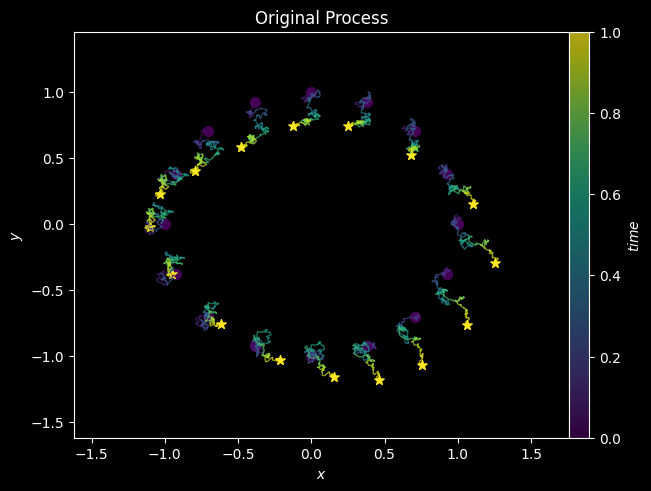

In [6]:
plot_landmark_sample_path(ori_path[1], m_landmarks, title="Original Process")

<Axes: title={'center': 'Auxiliary Process'}, xlabel='$x$', ylabel='$y$'>

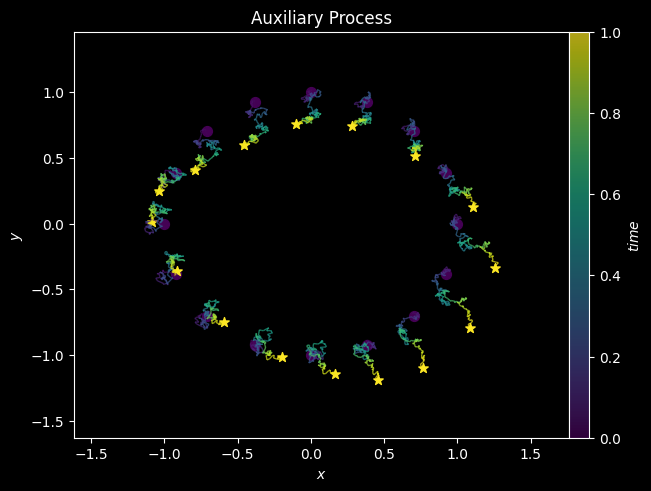

In [7]:
aux_path = aux_solver.solve(x0=u, rng_key=jax.random.PRNGKey(seed), batch_size=16)
plot_landmark_sample_path(aux_path[1], m_landmarks, title="Auxiliary Process")

In [8]:
guided_proc = GuidedBridgeProcess(
    ori_proc=ori_proc,
    aux_proc=aux_proc,
    u=u,
    v=v,
    L0=jnp.eye(dim, dtype=dtype),
    Sigma0=jnp.eye(dim, dtype=dtype) * 1e-4,
    ts=jnp.arange(0, T + dt, dt, dtype=dtype),
    ode_solver_kernel=ode_solver_kernel
)
guided_solver = Euler(sde=guided_proc, wiener=wiener_proc)

In [9]:
guided_path = guided_solver.solve(x0=u, rng_key=jax.random.PRNGKey(seed), batch_size=16)

In [10]:
print(guided_path.log_ll)

[-21794.385 -15820.242 -17165.367 -24077.06  -19986.139 -20098.9
 -14906.096 -20213.781 -12071.034 -24006.979 -20501.28  -23500.541
 -18532.295  -9968.134 -18913.875 -17421.771]


<Axes: title={'center': 'Guided Process'}, xlabel='$x$', ylabel='$y$'>

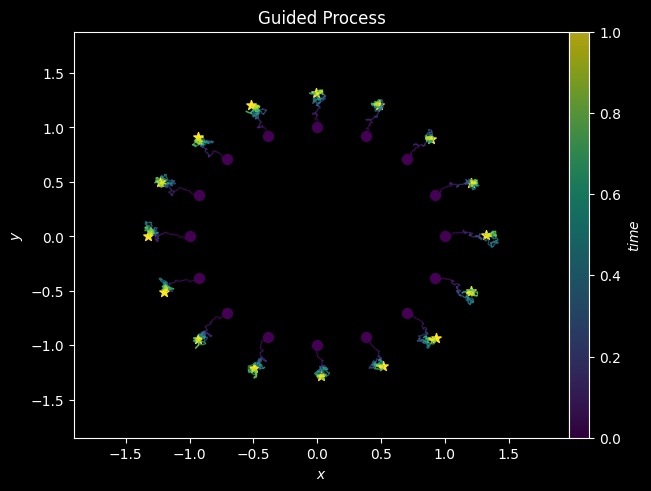

In [10]:
plot_landmark_sample_path(guided_path[1], m_landmarks, title="Guided Process")

In [11]:
net = ScoreNet(out_dim=dim, 
               hidden_dims=(32, 64, 128, 64, 32),
               norm="batch",
               t_emb_dim=32,
               t_emb_max_period=100.0,
               t_emb_scaling=200.0)

In [12]:
train_config = {
    "save_name": "landmarks_brownian_guided",
    "seed": seed,
    "learning_rate": 2e-4,
    "batch_size": 64,
    "n_iters": 1000,
    "n_epochs": 10,
    "ema_decay": 0.995,
    "optimizer": "adam",
    "clip_norm": None,
    "warmup_steps": 0
}

In [13]:
model = NeuralBridge(guided_proc, net, train_config)
model.init_path_solver(wiener_proc)
losses = model.train_neural_bridge(u=u, v=v, mode="train")

Training epochs:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 1:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 1 average loss: 0.03392
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/landmarks_brownian_guided/epoch_1


Epoch 2:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 2 average loss: 0.00809
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/landmarks_brownian_guided/epoch_2


Epoch 3:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 3 average loss: 0.00448
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/landmarks_brownian_guided/epoch_3


Epoch 4:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 4 average loss: 0.00316
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/landmarks_brownian_guided/epoch_4


Epoch 5:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 5 average loss: 0.00293
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/landmarks_brownian_guided/epoch_5


Epoch 6:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 6 average loss: 0.00188
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/landmarks_brownian_guided/epoch_6


Epoch 7:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 7 average loss: 0.00142
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/landmarks_brownian_guided/epoch_7


Epoch 8:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 8 average loss: 0.00142
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/landmarks_brownian_guided/epoch_8


Epoch 9:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 9 average loss: 0.00102
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/landmarks_brownian_guided/epoch_9


Epoch 10:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 10 average loss: 0.00077
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/landmarks_brownian_guided/epoch_10


In [14]:
neural_bridge = model.build_neural_bridge()

In [15]:
neural_bridge_solver = Euler(neural_bridge, wiener_proc)
neural_bridge_path = neural_bridge_solver.solve(x0=u, rng_key=jax.random.PRNGKey(seed), batch_size=16)

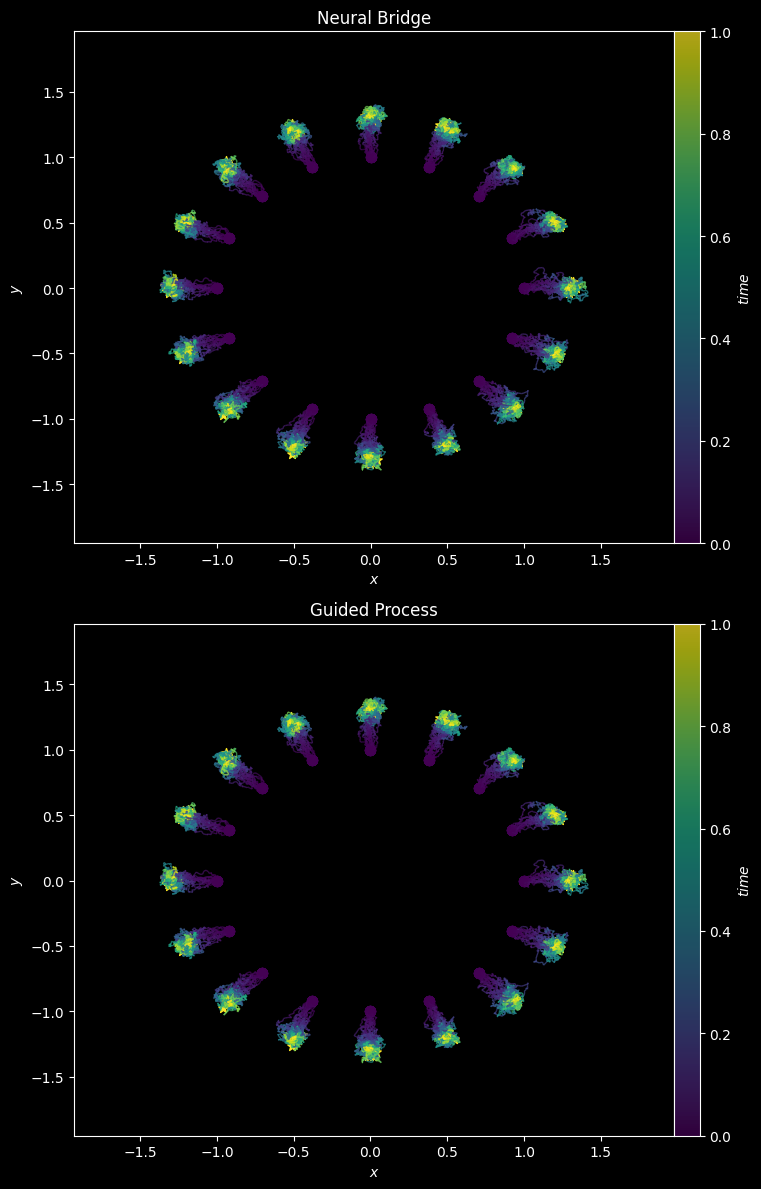

In [17]:
fig, axs = plt.subplots(2, 1, figsize=(8, 12))
plot_landmark_sample_path(neural_bridge_path[1:16], m_landmarks, ax=axs[0], title="Neural Bridge")
plot_landmark_sample_path(guided_path[1:16], m_landmarks, ax=axs[1], title="Guided Process")
plt.tight_layout()
plt.show()